In [2]:
import os
import json
import pickle

import numpy as np
import polars as pl
import nibabel as nib
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, Normalize

from sklearn.metrics import auc


## Testing labels

## Run the tester

In [ ]:
  # Make the script executable

In [ ]:
! bash baseline_test.sh

In [2]:
plt.style.use("seaborn-v0_8-white")

In [ ]:
ROOT_DIR = os.getcwd() #
WORKSPACE_DIR = os.path.join(ROOT_DIR, "workspace", "test")

In [ ]:
IMAGE_DIR = os.path.join(WORKSPACE_DIR, "imagesTs")
TRUE_LABEL_DIR = os.path.join(WORKSPACE_DIR, "labelsTs", "true")
PREDICTED_RESULTS_DIR = os.path.join(WORKSPACE_DIR, "labelsTs", "predicted")
PREDICTED_MAP_DIR = os.path.join(PREDICTED_RESULTS_DIR, "pdac-detection-map")

In [ ]:
PDAC_LABEL_ID = 1
LABEL_ANNOTATIONS = {
    0: "Background",
    1: "PDAC lesion",
    2: "Veins",
    3: "Arteries",
    4: "Pancreas parenchyma",
    5: "Pancreatic duct",
    6: "Common bile duct",
}


In [ ]:
RESULTS_DIR = os.path.join(ROOT_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True) 
LABEL_DISTRIBUTIONS_PATH = os.path.join(RESULTS_DIR, "label_distributions.pkl")

In [ ]:
pdac_likelihood_json_path = os.path.join(PREDICTED_RESULTS_DIR, "pdac-likelihood.json")
try:
    with open(pdac_likelihood_json_path, "r") as f:
        data = json.load(f)
except FileNotFoundError:
    print(f"Error: PDAC likelihood JSON file not found at {pdac_likelihood_json_path}")
    # Handle error appropriately, e.g., exit or use dummy data
    data = {}

# Convert the dict to a list of dicts and create a DataFrame
rows = [{"id": key, "pdac_likelihood": value} for key, value in data.items()]
predicted_pdac_scores_df = pl.DataFrame(
    rows,
    schema={
        "id": pl.Utf8,
        "pdac_likelihood": pl.Float64,
    },
)

In [ ]:
def get_label_distribution_for_image(label_filename: str, true_label_dir: str) -> dict:
    """
    Calculates the distribution of labels for a given NIfTI label image file.

    Args:
        label_filename: The filename of the label image (e.g., "100006_00001.nii.gz").
        true_label_dir: The directory containing the true label files.

    Returns:
        A dictionary mapping label IDs to their counts.
    """
    try:
        label_image_path = os.path.join(true_label_dir, label_filename)
        label_image = nib.load(label_image_path)
        data_arr = np.asanyarray(label_image.dataobj)
        unique_labels, counts = np.unique(data_arr, return_counts=True)
        return {int(label): int(count) for label, count in zip(unique_labels, counts)}
    except FileNotFoundError:
        print(f"Warning: Label file not found at {label_image_path}. Returning empty distribution.")
        return {}
    except Exception as e:
        print(f"Warning: Error processing {label_filename}: {e}. Returning empty distribution.")
        return {}

def get_image_data(image_filename: str, image_dir: str) -> np.ndarray | None:
    """
    Loads the data array from a NIfTI image file.

    Args:
        image_filename: The filename of the image (e.g., "100006_00001_0000.nii.gz").
        image_dir: The directory containing the image files.

    Returns:
        A NumPy array containing the image data, or None if an error occurs.
    """
    try:
        image_path = os.path.join(image_dir, image_filename)
        image = nib.load(image_path)
        return np.asanyarray(image.dataobj)
    except FileNotFoundError:
        print(f"Warning: Image file not found at {image_path}. Returning None.")
        return None
    except Exception as e:
        print(f"Warning: Error loading image {image_filename}: {e}. Returning None.")
        return None

def check_pdac_lesion_presence(label_filename: str, true_label_dir: str, pdac_label_id: int) -> bool:
    """Checks if a PDAC lesion is present in the label image file."""
    label_dist = get_label_distribution_for_image(label_filename, true_label_dir)
    return label_dist.get(pdac_label_id, 0) > 0

def convert_label_id_to_image_id(label_filename: str, suffix: str = "_0000") -> str:
    """
    Converts a label filename to a corresponding image filename convention.
    Example: "100006_00001.nii.gz" -> "100006_00001_0000.nii.gz"

    Args:
        label_filename: The label filename.
        suffix: The suffix to insert before the extension(s).

    Returns:
        The corresponding image filename.
    """
    parts = label_filename.split('.', 1) # Split only on the first dot
    base_name = parts[0]
    extensions = parts[1] if len(parts) > 1 else ""
    return f"{base_name}{suffix}.{extensions}" if extensions else f"{base_name}{suffix}"


In [ ]:
true_label_files = os.listdir(TRUE_LABEL_DIR)
if true_label_files:
    example_label_filename = true_label_files[0] # Using the first file as an example
    example_label_path = os.path.join(TRUE_LABEL_DIR, example_label_filename)
    try:
        example_label_image = nib.load(example_label_path)
        example_image_arr = np.asanyarray(example_label_image.dataobj)
        print(f"Shape of an example true label image ('{example_label_filename}'): {example_image_arr.shape}")
    except Exception as e:
        print(f"Could not load example image '{example_label_filename}': {e}")
else:
    print("No true label files found in directory.")

In [ ]:
if not predicted_pdac_scores_df.is_empty():
    predicted_pdac_scores_df = predicted_pdac_scores_df.with_columns(
        (pl.col("pdac_likelihood") < 0.5).cast(pl.Int8).alias("predicted_below_threshold")
    )
    score_distribution = predicted_pdac_scores_df.group_by(["predicted_below_threshold"]).agg(
        [
            pl.count().alias("count"),
        ]
    ).sort("predicted_below_threshold")
    print("Distribution of predicted PDAC likelihoods (0: >= 0.5, 1: < 0.5):")
    print(score_distribution)
else:
    print("Predicted PDAC scores DataFrame is empty. Skipping distribution analysis.")


In [ ]:
if os.path.exists(LABEL_DISTRIBUTIONS_PATH):
    print(f"Loading cached label distributions from: {LABEL_DISTRIBUTIONS_PATH}")
    with open(LABEL_DISTRIBUTIONS_PATH, "rb") as f:
        label_distributions_map = pickle.load(f)
else:
    print("Computing label distributions (this may take a while)...")
    label_distributions_map = {
        filename: get_label_distribution_for_image(filename, TRUE_LABEL_DIR)
        for filename in tqdm(true_label_files, desc="Processing label files") # tqdm added back here
    }
    # Filter out empty distributions if any files failed to load
    label_distributions_map = {k: v for k, v in label_distributions_map.items() if v}
    print(f"Saving computed label distributions to: {LABEL_DISTRIBUTIONS_PATH}")
    with open(LABEL_DISTRIBUTIONS_PATH, "wb") as f:
        pickle.dump(label_distributions_map, f)

if not label_distributions_map:
    print("Error: Label distributions map is empty. Cannot proceed with ROC analysis.")
    # Consider exiting or handling this case
else:
    # Example: Count images with and without PDAC
    pdac_presence = [dist.get(PDAC_LABEL_ID, 0) > 0 for dist in label_distributions_map.values()]
    unique_pdac_counts, counts_pdac = np.unique(pdac_presence, return_counts=True)
    print("PDAC presence in true labels:")
    for val, count in zip(unique_pdac_counts, counts_pdac):
        print(f"- {'Contains PDAC' if val else 'No PDAC'}: {count} images")

## ROC

* get the class probability thresholds [0, 1]
* determine if there is PDAC in the label
* get a confusion matrix for the test data, given the threshold
* get the true positive rate (TPR) and false positive rate (FPR)
* plot the ROC curve for all the thresholds
* get the area under the curve (AUC) for the ROC curve


In [11]:
class_thresholds = np.linspace(0, 1, 100)

In [33]:
label_distributions = {
    label: get_label_distribution_for_image_labels(label) for label in true_labels
}

In [46]:
np.save('./results/label_distributions.npy', label_distributions)

In [15]:
label_distributions = np.load('./results/label_distributions.npy', allow_pickle=True).item()

In [16]:
def get_cm_for_threshold(threshold: float) -> np.ndarray:
    cm = np.zeros((2, 2), dtype=int)
    for label, distribution in label_distributions.items():
        pdac_score = (
            predicted_pdac_scores.filter(pl.col("id") == label[:-7]+"_0000")
            .get_column("pdac_likelihood")
            .to_numpy()[0]
        )
        true_label = distribution.get(PDAC_LABEL, 0) > 0
        predicted_label = pdac_score > threshold
        cm[int(true_label), int(predicted_label)] += 1

    return cm

In [17]:
def plot_cm(threshold: float):
    cm = get_cm_for_threshold(threshold)
    fig, ax = plt.subplots()
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["No PDAC", "PDAC"],
        yticklabels=["No PDAC", "PDAC"],
        ax=ax,
    )
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(f"Confusion Matrix at Threshold {threshold:.2f}")
    plt.show()

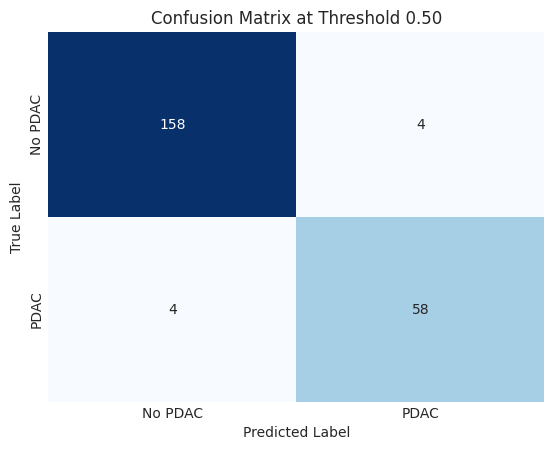

In [18]:
plot_cm(0.5)

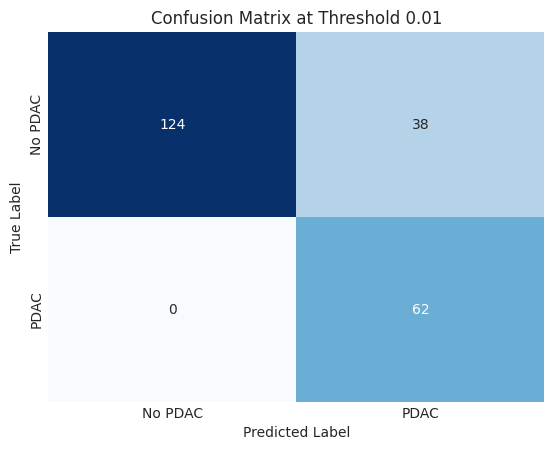

In [19]:
plot_cm(0.01)

In [20]:
def get_tpr_and_fpr(threshold: float) -> tuple:
    cm = get_cm_for_threshold(threshold)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return tpr, fpr

In [21]:
def plot_roc_with_auc_score():
    tpr_list = []
    fpr_list = []
    for threshold in class_thresholds:
        tpr, fpr = get_tpr_and_fpr(threshold)
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    auc_score = auc(fpr_list, tpr_list)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_list, tpr_list, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.fill_between(fpr_list, tpr_list, alpha=0.2)

    # add AUC score to the plot
    plt.text(
        0.5,
        0.2,
        f"AUC: {auc_score:.2f}",
        fontsize=12,
        ha="center",
        va="center",
        bbox=dict(facecolor="white", alpha=0.5),
    )
    plt.title("ROC Curve with AUC Score")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.show()

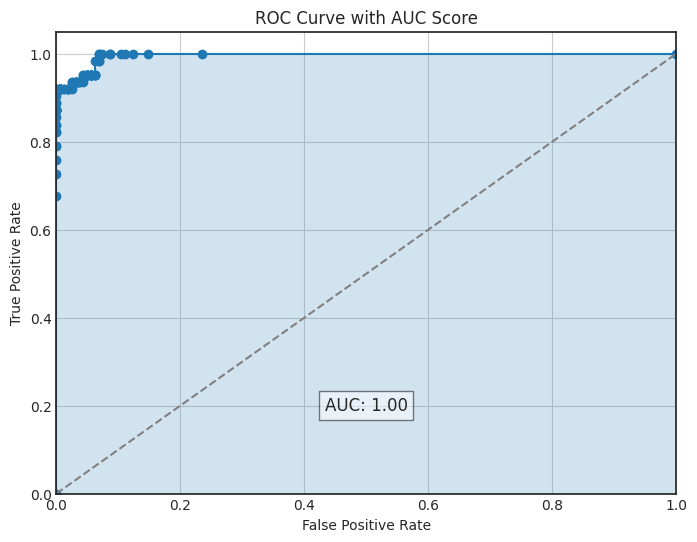

In [22]:
plot_roc_with_auc_score()

# Samples
* get a sample with no PDAC and a sample with PDAC
* get the predicted probability (incl. class) for each sample
* get saggital, mid, and axial slices for each sample and plot the true labels on top
* plot the predicted PDAC area, segmentation, for each samples


In [ ]:
def get_slice_with_most_pdac(label_data_arr: np.ndarray, pdac_label_id: int) -> int:
    """
    Finds the index of the slice (along axis 2) with the maximum number of PDAC-labeled voxels.
    """
    if label_data_arr.ndim != 3:
        print("Warning: Expected 3D array for label data.")
        return label_data_arr.shape[2] // 2 # Default to middle slice

    pdac_counts_per_slice = np.sum(label_data_arr == pdac_label_id, axis=(0, 1))
    if np.sum(pdac_counts_per_slice) == 0: # No PDAC in any slice
        return label_data_arr.shape[2] // 2 # Default to middle if no PDAC
    return int(np.argmax(pdac_counts_per_slice))

In [ ]:
def plot_true_and_predicted_segmentation_overlay(
    true_label_filename: str, # e.g., "100134_00001.nii.gz"
    image_dir: str,
    true_label_dir: str,
    predicted_map_dir: str, # Directory for predicted segmentation maps
    pdac_label_id: int,
):
    """
    Plots the original image slice with true PDAC segmentation and predicted PDAC segmentation overlaid.
    The predicted map filename is inferred from the true_label_filename.
    """
    # --- 1. Load True Label Data ---
    true_label_data = get_image_data(true_label_filename, true_label_dir)
    if true_label_data is None:
        print(f"Could not load true label data for {true_label_filename}.")
        return

    # --- 2. Determine Best Slice ---
    # Choose the slice with the highest PDAC pixel count from true labels
    slice_idx = get_slice_with_most_pdac(true_label_data, pdac_label_id)

    # --- 3. Load Original Image Slice ---
    # Infer original image filename (e.g., "100134_00001.nii.gz" -> "100134_00001_0000.nii.gz")
    image_filename = convert_label_id_to_image_id(true_label_filename)
    original_image_data = get_image_data(image_filename, image_dir)
    if original_image_data is None:
        print(f"Could not load original image data for {image_filename}.")
        return
    
    if slice_idx >= original_image_data.shape[2]:
        print(f"Warning: Slice index {slice_idx} is out of bounds for image {image_filename}. Using middle slice.")
        slice_idx = original_image_data.shape[2] // 2
        
    axial_image_slice = original_image_data[:, :, slice_idx].T # Transpose for typical medical image view

    # --- 4. Load Predicted PDAC Map Slice ---
    # Infer predicted map filename (e.g., "100134_00001.nii.gz" -> "100134_00001_0000.nii.gz")
    predicted_map_filename = convert_label_id_to_image_id(true_label_filename) # Assumes same naming convention
    predicted_pdac_map_data = get_image_data(predicted_map_filename, predicted_map_dir)

    predicted_pdac_map_slice = None
    if predicted_pdac_map_data is not None:
        if slice_idx >= predicted_pdac_map_data.shape[2]:
            print(f"Warning: Slice index {slice_idx} is out of bounds for predicted map {predicted_map_filename}. Not showing prediction.")
        else:
            predicted_pdac_map_slice = predicted_pdac_map_data[:, :, slice_idx].T # Transpose
    else:
        print(f"Predicted PDAC map not found or failed to load for {predicted_map_filename}. Plotting true labels only.")

    # --- 5. Prepare True Label Slice and Mask ---
    true_label_slice = true_label_data[:, :, slice_idx].T # Transpose
    true_pdac_mask_slice = (true_label_slice == pdac_label_id).astype(float)

    # --- 6. Plotting ---
    fig, ax = plt.subplots(figsize=(10, 8)) # Adjusted size
    ax.imshow(axial_image_slice, cmap="gray", origin="lower")

    # Overlay true PDAC lesion
    if np.sum(true_pdac_mask_slice) > 0:
        ax.imshow(true_pdac_mask_slice, cmap=ListedColormap(["none", "deeppink"]), alpha=0.4, origin="lower", label="True PDAC")
    else:
        print(f"No true PDAC lesion found on slice {slice_idx} for {true_label_filename}.")
        # Still add label for legend consistency if needed, or handle differently
        # ax.plot([], [], color='deeppink', alpha=0.4, label="True PDAC (not present on slice)")


    # Overlay predicted PDAC lesion
    if predicted_pdac_map_slice is not None and np.sum(predicted_pdac_map_slice) > 0 : # Assuming prediction is binary or probability map > 0
        # If it's a probability map, you might want to threshold it first
        # Example: predicted_pdac_map_slice = (predicted_pdac_map_slice > 0.5).astype(float)
        ax.imshow(predicted_pdac_map_slice, cmap=ListedColormap(["none", "cyan"]), alpha=0.4, origin="lower", label="Predicted PDAC")
    elif predicted_pdac_map_slice is not None:
        print(f"No predicted PDAC lesion found on slice {slice_idx} for {predicted_map_filename}.")
        # ax.plot([], [], color='cyan', alpha=0.4, label="Predicted PDAC (not present on slice)")


    ax.set_title(f"PDAC Segmentation Overlay\nImage: {image_filename}, Slice: {slice_idx}")
    ax.axis("off")
    # Create legend handles manually for better control if overlays might be absent
    handles = []
    if np.sum(true_pdac_mask_slice) > 0: # Only add if present
        handles.append(plt.Line2D([0], [0], color='deeppink', lw=4, alpha=0.6, label='True PDAC'))
    if predicted_pdac_map_slice is not None and np.sum(predicted_pdac_map_slice) > 0: # Only add if present
        handles.append(plt.Line2D([0], [0], color='cyan', lw=4, alpha=0.6, label='Predicted PDAC'))
    
    if handles:
        ax.legend(handles=handles, loc="upper right")
    else: # No PDAC true or predicted on slice
        ax.legend([plt.Line2D([0], [0], color='gray', lw=0, label='No PDAC detected on this slice')], loc="upper right")


    plt.tight_layout()
    plt.show()

In [ ]:
sample_to_plot = None
if label_distributions_map:
    # Try to find a PDAC positive sample from the label distributions
    pdac_positive_samples = [
        fname for fname, dist in label_distributions_map.items()
        if dist.get(PDAC_LABEL_ID, 0) > 0
    ]
    if pdac_positive_samples:
        sample_to_plot = pdac_positive_samples[0] # Plot the first one found
        print(f"\nVisualizing sample with PDAC: {sample_to_plot}")
    else:
        print("\nNo PDAC-positive samples found in true labels for visualization example.")
        # Optionally, pick any sample if none are PDAC positive
        if true_label_files:
             sample_to_plot = true_label_files[0]
             print(f"Visualizing a PDAC-negative sample as fallback: {sample_to_plot}")

if sample_to_plot:
    plot_true_and_predicted_segmentation_overlay(
        true_label_filename=sample_to_plot,
        image_dir=IMAGE_DIR,
        true_label_dir=TRUE_LABEL_DIR,
        predicted_map_dir=PREDICTED_MAP_DIR, # Use the defined constant
        pdac_label_id=PDAC_LABEL_ID,
    )
else:
    print("No sample available to plot segmentation.")

In [ ]:
CLASSIFICATION_THRESHOLD = 0.5

false_negative_samples_list = []
false_positive_samples_list = []

if label_distributions_map and not predicted_pdac_scores_df.is_empty():
    for label_filename, distribution in label_distributions_map.items():
        true_has_pdac = distribution.get(PDAC_LABEL_ID, 0) > 0
        
        # Match ID for prediction lookup
        base_name = label_filename.split(".")[0]
        pred_id_for_lookup = f"{base_name}_0000"
        
        score_series = predicted_pdac_scores_df.filter(pl.col("id") == pred_id_for_lookup).select("pdac_likelihood")

        if score_series.is_empty():
            continue # Skip if no score found

        pdac_likelihood_score = score_series.item()
        predicted_has_pdac = pdac_likelihood_score >= CLASSIFICATION_THRESHOLD

        if true_has_pdac and not predicted_has_pdac:
            false_negative_samples_list.append({
                "filename": label_filename,
                "true_pdac_voxels": distribution.get(PDAC_LABEL_ID, 0),
                "predicted_likelihood": pdac_likelihood_score
            })
        elif not true_has_pdac and predicted_has_pdac:
            false_positive_samples_list.append({
                "filename": label_filename,
                "predicted_likelihood": pdac_likelihood_score
            })
    
    print(f"\nFound {len(false_negative_samples_list)} False Negative samples (True PDAC, Predicted No PDAC at threshold {CLASSIFICATION_THRESHOLD}).")
    # for fn_sample in false_negative_samples_list[:3]: # Print first 3
    #     print(f"  - FN: {fn_sample['filename']}, True Voxels: {fn_sample['true_pdac_voxels']}, Predicted Score: {fn_sample['predicted_likelihood']:.3f}")

    print(f"Found {len(false_positive_samples_list)} False Positive samples (No True PDAC, Predicted PDAC at threshold {CLASSIFICATION_THRESHOLD}).")
    # for fp_sample in false_positive_samples_list[:3]: # Print first 3
    #     print(f"  - FP: {fp_sample['filename']}, Predicted Score: {fp_sample['predicted_likelihood']:.3f}")

    # Further analysis: visualize some of these misclassified samples
    if false_negative_samples_list:
        random_fn_sample_info = np.random.choice(false_negative_samples_list) # Select one dict
        print(f"\nVisualizing a random False Negative sample: {random_fn_sample_info['filename']}")
        plot_true_and_predicted_segmentation_overlay(
            random_fn_sample_info['filename'], IMAGE_DIR, TRUE_LABEL_DIR, PREDICTED_MAP_DIR, PDAC_LABEL_ID
        )
    
    if false_positive_samples_list:
        random_fp_sample_info = np.random.choice(false_positive_samples_list) # Select one dict
        print(f"\nVisualizing a random False Positive sample: {random_fp_sample_info['filename']}")
        plot_true_and_predicted_segmentation_overlay(
            random_fp_sample_info['filename'], IMAGE_DIR, TRUE_LABEL_DIR, PREDICTED_MAP_DIR, PDAC_LABEL_ID
        )

else:
    print("Skipping misclassified sample analysis due to missing data.")
